In [15]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
import scanorama

In [31]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.2


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/singlecell/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

In [4]:
adata_combat = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Combat_T_cell.h5ad")

In [5]:
adata_combat.raw = adata_combat

In [7]:
#adata = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Concatenate_T_cell.h5ad")

In [4]:
adata = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/NotCorrected_T_cell.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 44709 × 18811
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_ribo', 'percent_mito', 'dataset'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'gene_id-6', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
import desc
import keras
keras.__version__
import pydot
pydot.__version__

'1.4.1'

In [7]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb')
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

In [8]:
out = adata.copy()

In [ ]:
out = desc.scale_bygroup(out, groupby='dataset', max_value=6)
out = desc.train(out,
                     dims=[adata.shape[1],128,32],
                     tol=0.001,
                     n_neighbors=10,
                     batch_size=256,
                     louvain_resolution=0.8,
                     save_encoder_weights=False,
                     save_dir="/home/spuccio/datadisk2/tmp/",
                     do_tsne=False,
                     use_GPU=False,
                     num_Cores=20,
                     use_ae_weights=False,
                     do_umap=False)

In [10]:
out.obsm['X_emb'] = out.obsm['X_Embeded_z'+str(0.8)]
run_vis(adata)
run_vis(out)

computing PCA
    on highly variable genes
    with n_comps=50


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:48)


In [35]:
out.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R08_cell.h5ad")

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [34]:
sc.pl.umap(adata, color='dataset'); plt.show()
sc.pl.umap(out, color='dataset'); plt.show()

In [28]:
sc.pl.umap(out, color=['CD8A','CD4','CD3E'],color_map=mymap,use_raw=False,s=10); plt.show()

NameError: name 'mymap' is not defined

In [ ]:
out2 = adata.copy()
out_2 = desc.scale_bygroup(out2, groupby='dataset', max_value=6)
out_2 = desc.train(out_2,
                     dims=[adata.shape[1],128,32],
                     tol=0.001,
                     n_neighbors=10,
                     batch_size=256,
                     louvain_resolution=0.6,
                     save_encoder_weights=False,
                     save_dir="/home/spuccio/datadisk2/tmp/",
                     do_tsne=False,
                     use_GPU=False,
                     num_Cores=20,
                     use_ae_weights=False,
                     do_umap=False)

In [42]:
out_2.obsm['X_emb'] = out_2.obsm['X_Embeded_z'+str(0.6)]

In [43]:
run_vis(out_2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)


In [44]:
out_2.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R06_cell.h5ad")

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [39]:
sc.pl.umap(adata, color='dataset'); plt.show()
sc.pl.umap(out, color='dataset'); plt.show()
sc.pl.umap(out_2, color='dataset'); plt.show()

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


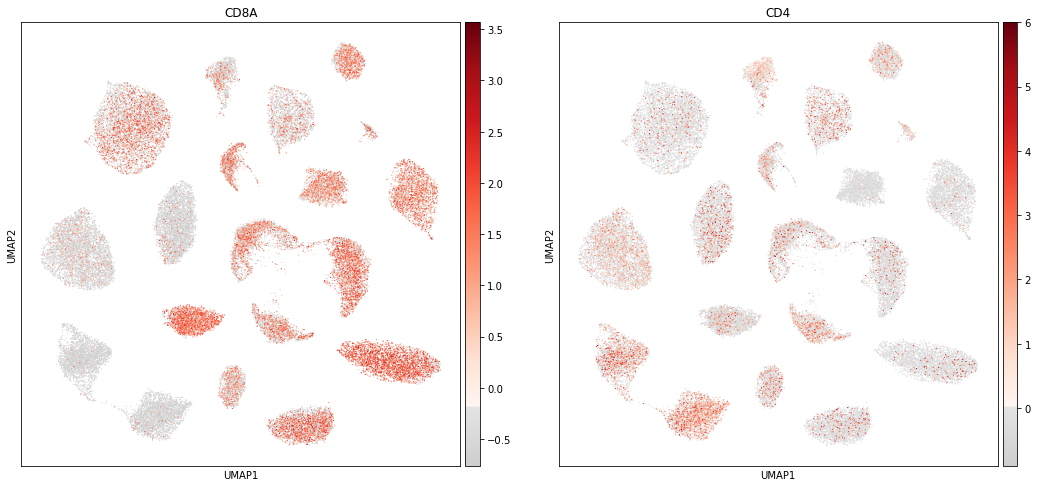

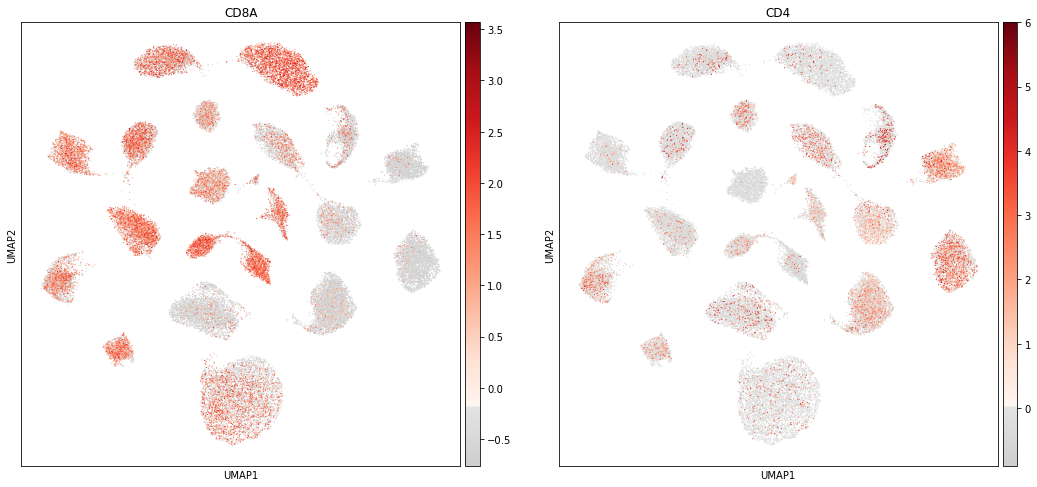

In [78]:
sc.pl.umap(out, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()
sc.pl.umap(out_2, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()

In [ ]:
out3 = adata.copy()
out_3 = desc.scale_bygroup(out3, groupby='dataset', max_value=6)
out_3 = desc.train(out_3,
                     dims=[adata.shape[1],128,32],
                     tol=0.001,
                     n_neighbors=20,
                     batch_size=256,
                     louvain_resolution=0.6,
                     save_encoder_weights=False,
                     save_dir="/home/spuccio/datadisk2/tmp/",
                     do_tsne=False,
                     use_GPU=False,
                     num_Cores=20,
                     use_ae_weights=False,
                     do_umap=False,
                  verbose=False)

In [45]:
out_3.obsm['X_emb'] = out_3.obsm['X_Embeded_z'+str(0.6)]

In [46]:
run_vis(out_3)
sc.pl.umap(adata, color='dataset'); plt.show()
sc.pl.umap(out, color='dataset'); plt.show()
sc.pl.umap(out_2, color='dataset'); plt.show()
sc.pl.umap(out_3, color='dataset'); plt.show()

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [47]:
out_3.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R06_K20_cell.h5ad")

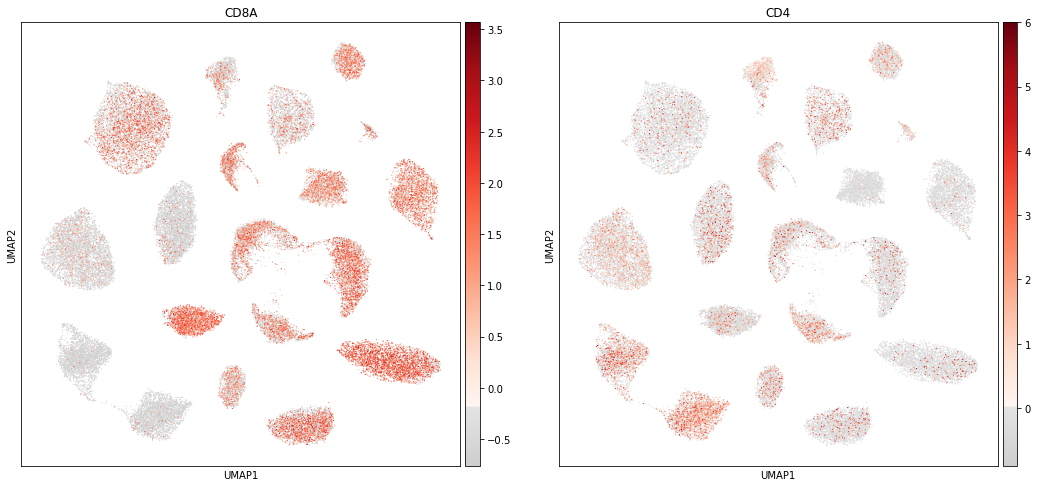

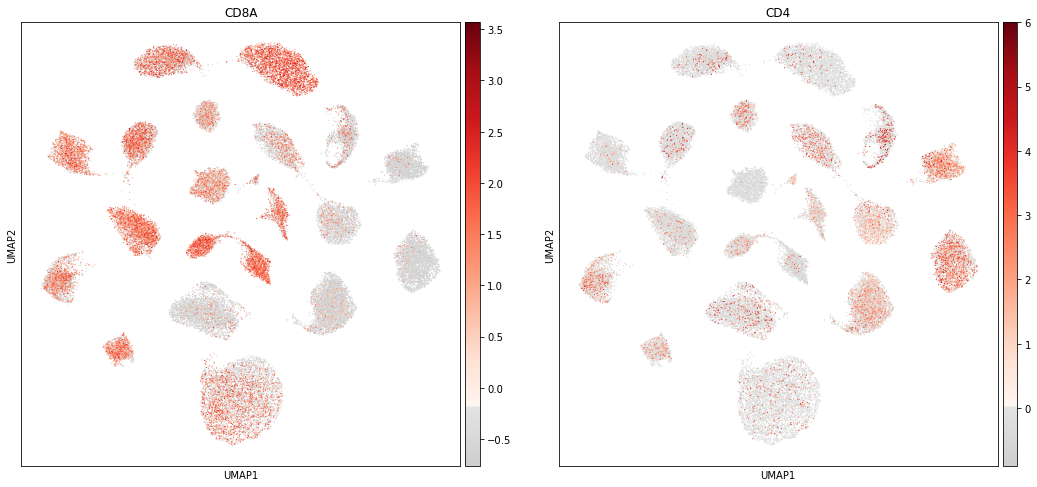

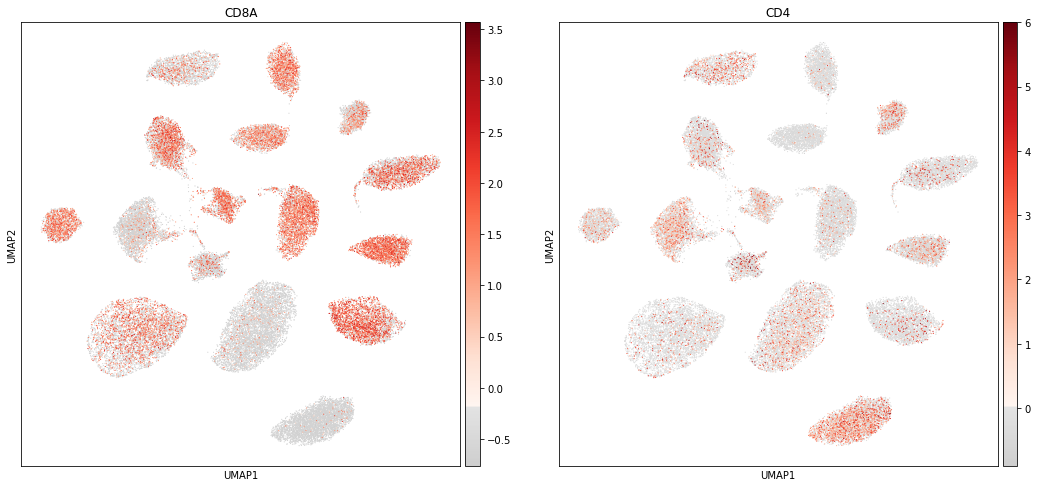

In [84]:
sc.pl.umap(out, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()
sc.pl.umap(out_2, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()
sc.pl.umap(out_3, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()

In [ ]:
out4 = adata.copy()
out_4 = desc.scale_bygroup(out4, groupby='dataset', max_value=6)
out_4 = desc.train(out_4,
                     dims=[adata.shape[1],128,32],
                     tol=0.001,
                     n_neighbors=30,
                     batch_size=256,
                     louvain_resolution=0.6,
                     save_encoder_weights=False,
                     save_dir="/home/spuccio/datadisk2/tmp/",
                     do_tsne=False,
                     use_GPU=False,
                     num_Cores=20,
                     use_ae_weights=False,
                     do_umap=False,
                  verbose=False)

In [48]:
out_4.obsm['X_emb'] = out_4.obsm['X_Embeded_z'+str(0.6)]

In [49]:
run_vis(out_4)
sc.pl.umap(adata, color='dataset'); plt.show()
sc.pl.umap(out, color='dataset'); plt.show()
sc.pl.umap(out_2, color='dataset'); plt.show()
sc.pl.umap(out_3, color='dataset'); plt.show()
sc.pl.umap(out_4, color='dataset'); plt.show()

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [50]:
out_4.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R06_K30_cell.h5ad")

In [ ]:
sc.pl.umap(out, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()
sc.pl.umap(out_2, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()
sc.pl.umap(out_3, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()
sc.pl.umap(out_4, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


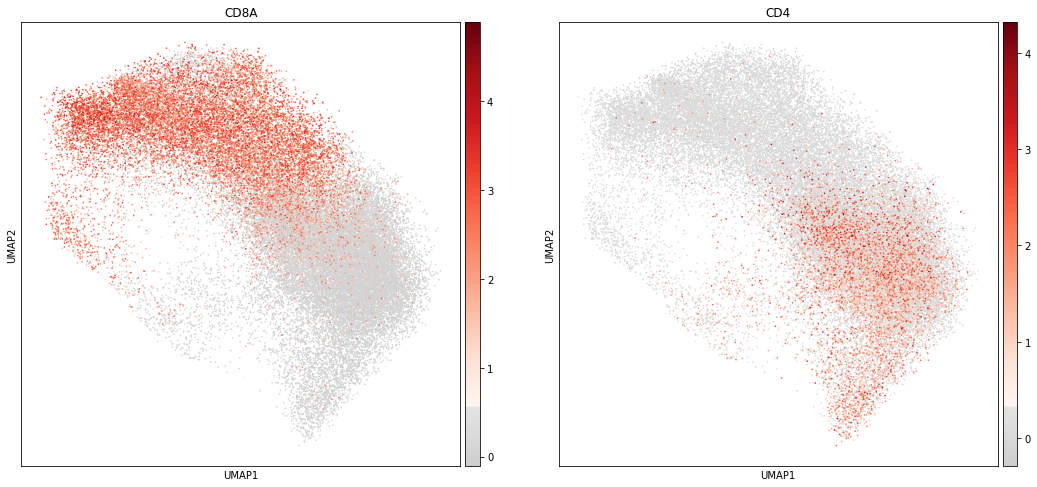

In [8]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.umap(adata_combat, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=10); plt.show()

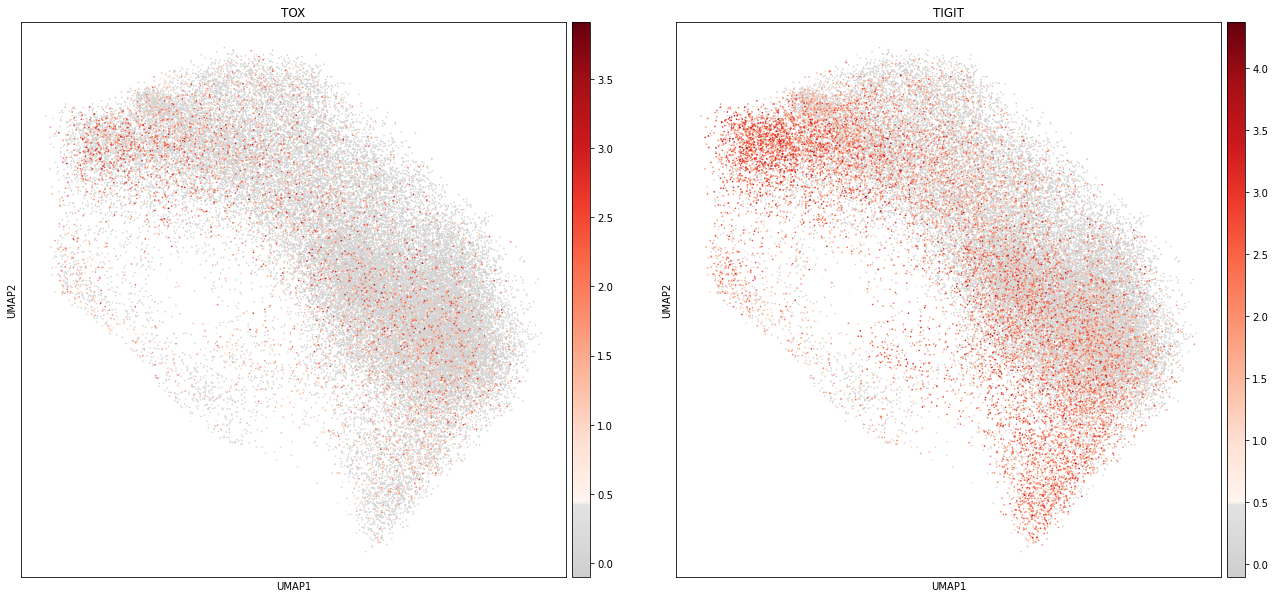

In [14]:
sc.pl.umap(adata_combat, color=['TOX','TIGIT'],color_map=mymap,use_raw=False,s=10); plt.show()

In [77]:
sc.tl.louvain(out2, resolution=0.9, key_added= 'leiden_r8_clusters', random_state=10)
sc.tl.louvain(out2, resolution=0.8, key_added= 'leiden_r8_clusters', random_state=10)
sc.tl.louvain(out2, resolution=0.7, key_added= 'leiden_r7_clusters', random_state=10)
sc.tl.louvain(out2,resolution=0.6, key_added= 'leiden_r6_clusters',random_state=10)
sc.tl.louvain(out2, resolution=0.5, key_added= 'leiden_r5_clusters', random_state=10)
sc.tl.louvain(out2, resolution=0.4, key_added= 'leiden_r4_clusters', random_state=10)
sc.tl.louvain(out2, resolution=0.3, key_added= 'leiden_r4_clusters', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'leiden_r8_clusters', the cluster labels (adata.obs, categorical) (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'leiden_r8_clusters', the cluster labels (adata.obs, categorical) (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)


KeyboardInterrupt: 

In [ ]:
%%R -i adata_lungTcell

clustree(adata_combat,prefix="leiden_r",suffix = "_clusters",exprs = "X")

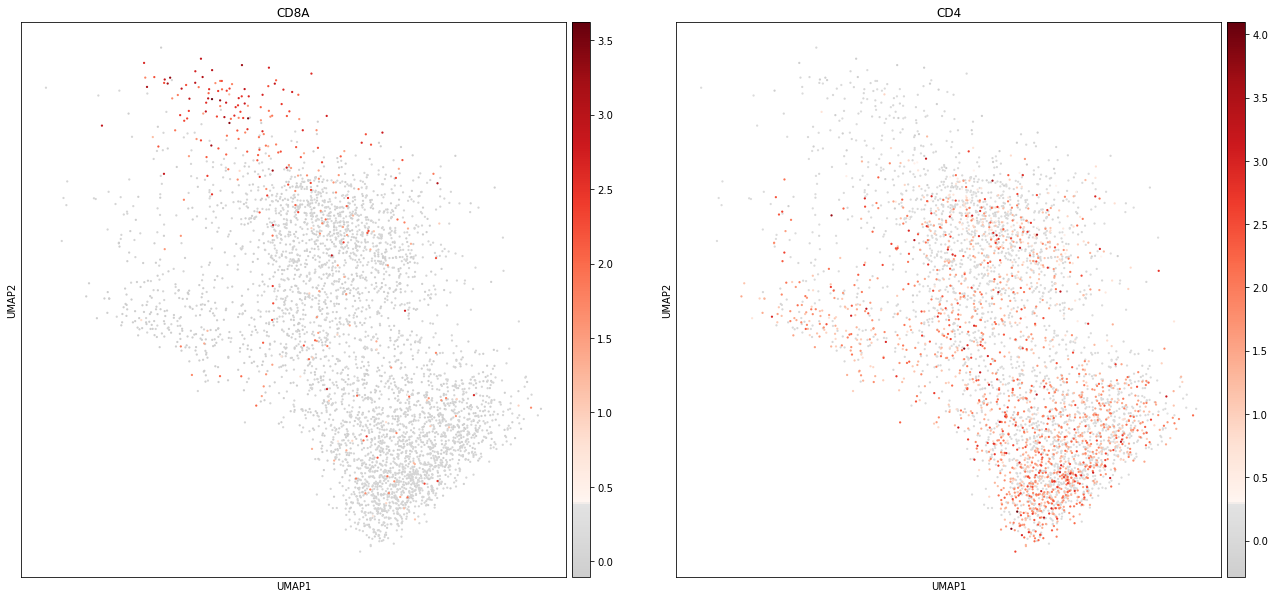

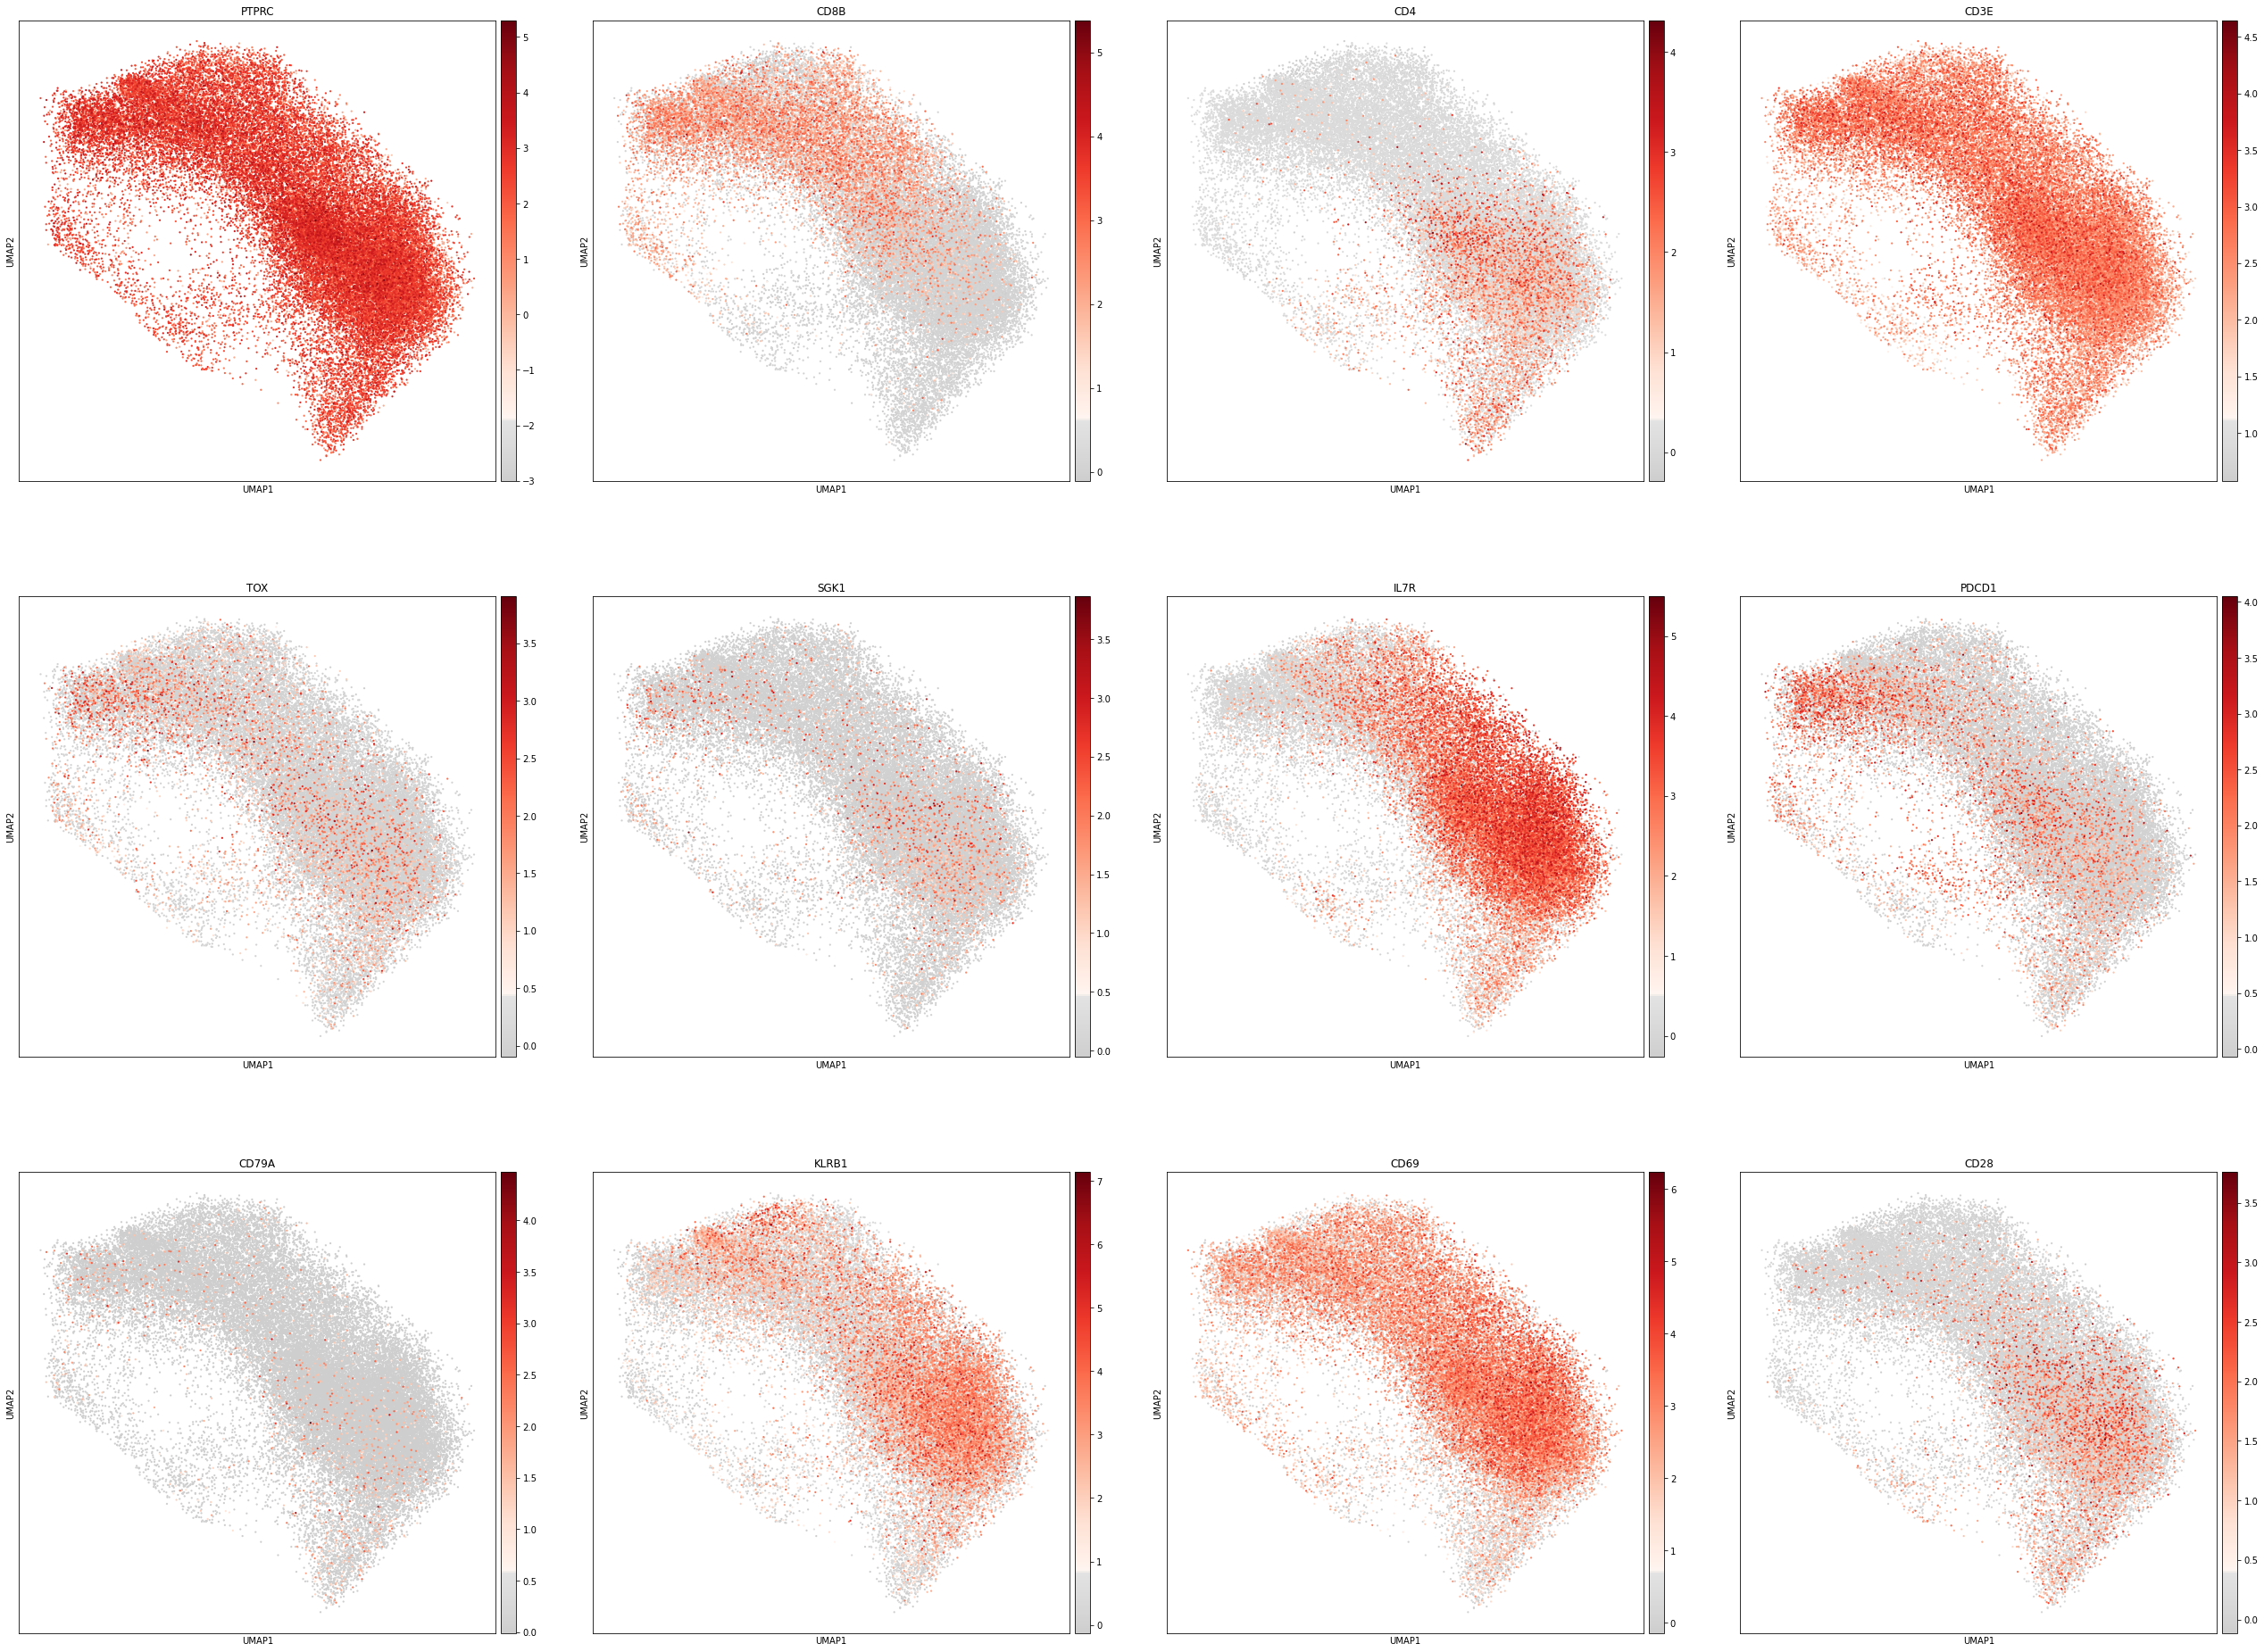

In [56]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata_combat[adata_combat.obs['louvain_r0.6'].isin(['5']),:], color=['CD8A','CD4'],legend_loc='on data',s=20,color_map=mymap)
sc.pl.umap(adata_combat,color=['PTPRC','CD8B','CD4','CD3E','TOX','SGK1','IL7R','PDCD1','CD79A','KLRB1','CD69','CD28'],legend_loc='on data',s=20,color_map=mymap)

In [ ]:
%%R                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             -i adata_combat

clustree(adata_combat,prefix="leiden_r",suffix = "_clusters",exprs = "X")

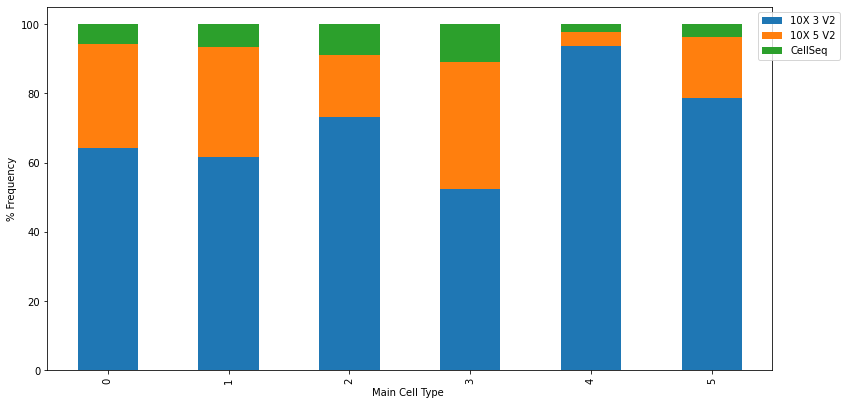

In [10]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata_combat.obs.groupby("louvain_r0.4")["batch"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Main Cell Type ")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

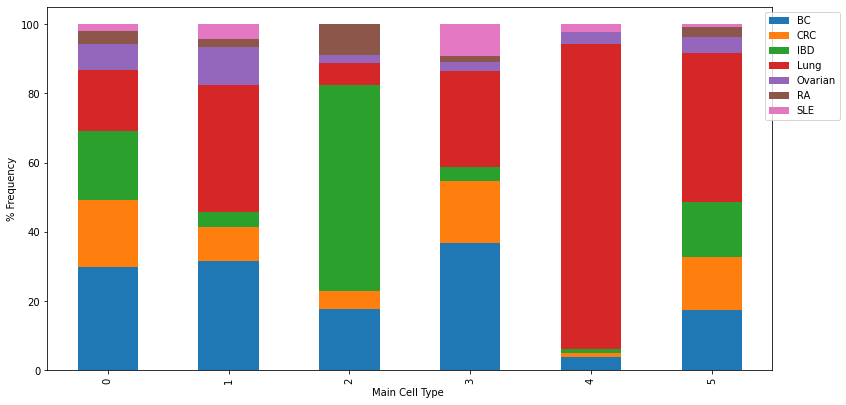

In [11]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata_combat.obs.groupby("louvain_r0.4")["TumorType"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Main Cell Type ")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [41]:
adata =  adata[adata_combat.obs['TumorType'],:]

IndexError: Unknown indexer ['RA', 'RA', 'RA', 'RA', 'RA', ..., 'BC', 'BC', 'BC', 'BC', 'BC']
Length: 44709
Categories (7, object): ['BC', 'CRC', 'IBD', 'Lung', 'Ovarian', 'RA', 'SLE'] of type <class 'pandas.core.arrays.categorical.Categorical'>

In [19]:
(adata_combat.obs["louvain_r0.4"])isin()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [27]:
adata_combat[adata_combat.obs['louvain_r0.4'].isin(['1','5']),:]

View of AnnData object with n_obs × n_vars = 16386 × 18811
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_ribo', 'percent_mito', 'dataset', 'louvain_r0.8', 'louvain_r0.6', 'louvain_r0.4'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'gene_id-6', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'neighbors', 'pca', 'umap', 'louvain', 'louvain_r0.6_colors', 'louvain_r0.4_colors', 'louvain_r0.8_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [28]:
adata_combat[adata_combat.obs['louvain_r0.4'].isin(['0','2','3','4']),:]

View of AnnData object with n_obs × n_vars = 28323 × 18811
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_ribo', 'percent_mito', 'dataset', 'louvain_r0.8', 'louvain_r0.6', 'louvain_r0.4'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'gene_id-6', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'neighbors', 'pca', 'umap', 'louvain', 'louvain_r0.6_colors', 'louvain_r0.4_colors', 'louvain_r0.8_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [4]:
df = pd.read_csv("/home/spuccio/isilon/SP028_Autoimmunity/cluster_counts.txt",sep="\t",header=0)

In [7]:
import pandas as pd
import seaborn as sns

In [8]:
df.head()

leiden_r6_clusters TumorType  TumorType.1        Frq
0                   0        BC         1587  12.712272
1                   1        BC          209   1.674143
2                   2        BC         1550  12.415892
3                   3        BC         1718  13.761615
4                   4        BC         1438  11.518744

In [23]:
df.columns = ['Cluster','Pathology','Raw_Freq','Frequency']

[Text(0, 0.5, '% Frequency')]

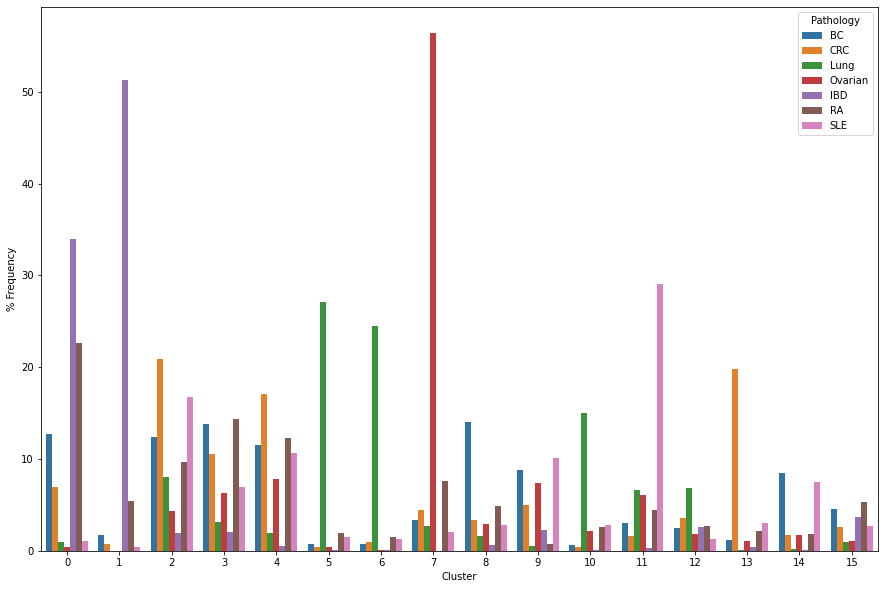

In [51]:
plt.rcParams['figure.figsize']=(15,10)
ax = sns.barplot(x="Cluster", y="Frequency", hue="Pathology", data=df,hue_order=["BC","CRC","Lung","Ovarian","IBD","RA","SLE"])
ax.set(ylabel='% Frequency')

In [48]:
fig = ax.get_figure()
fig.savefig("/home/spuccio/isilon/SP028_Autoimmunity/Barplot_Frequency.pdf",facecolor='white', transparent=True,format='pdf', dpi=300) 

In [21]:
?sns.barplot

Signature:
sns.barplot(
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    estimator=<function mean at 0x7fe52c251430>,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    errcolor='.26',
    errwidth=None,
    capsize=None,
    dodge=True,
    ax=None,
    **kwargs,
)
Docstring:
Show point estimates and confidence intervals as rectangular bars.

A bar plot represents an estimate of central tendency for a numeric
variable with the height of each rectangle and provides some indication of
the uncertainty around that estimate using error bars. Bar plots include 0
in the quantitative axis range, and they are a good choice when 0 is a
meaningful value for the quantitative variable, and you want to make
comparisons against it.

For datasets where 0 is not a meaningful value, a point plot will allow you
to focus on differences between levels of one or more categorical
v